In [41]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")


In [2]:
# on google sheets go to File>Share>Publish to Web>As CSV - and use that link

data_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSSFkyiphfNhBCMi84feI8v4SbeJkJub5vAN_jVgwUbjPLlPJ8UskzbWCtPOsqNmHgrv2CgnwbTr7ic/pub?output=csv'


In [3]:
df = pd.read_csv(data_url, parse_dates=['reporting_day'], infer_datetime_format=True)
df.head()

,ad_id,reporting_day,campaign_id,fb_campaign_id,age,gender,education,state,marital,impressions,clicks,spent,total_conversion,approved_conversion
0,708746,2017-08-15,936,103916,30-34,M,high.school,CA,married,7350,1,1.43,2,1
1,708749,2017-08-15,936,103917,30-34,M,professional.course,AZ,married,17861,2,1.82,2,0
2,708771,2017-08-15,936,103920,30-34,M,university.degree,UT,married,693,0,0.00,1,0
3,708815,2017-08-15,936,103928,30-34,M,high.school,NH,single,4259,1,1.25,1,0
4,708818,2017-08-15,936,103928,30-34,M,professional.course,AZ,single,4133,1,1.29,1,1


In [4]:
df.info()
print(f'duplicates {df.duplicated().sum().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ad_id                761 non-null    int64         
 1   reporting_day        761 non-null    datetime64[ns]
 2   campaign_id          761 non-null    int64         
 3   fb_campaign_id       761 non-null    int64         
 4   age                  761 non-null    object        
 5   gender               761 non-null    object        
 6   education            761 non-null    object        
 7   state                746 non-null    object        
 8   marital              761 non-null    object        
 9   impressions          761 non-null    int64         
 10  clicks               761 non-null    int64         
 11  spent                761 non-null    float64       
 12  total_conversion     761 non-null    int64         
 13  approved_conversion  761 non-null  

In [5]:
# No missing values besides on State, before deciding how to handle the missing values I'll check for the relevance of this feature
# No duplicates

# some of the columns are just ID's the only important ID will be campaign ID, so the others can be dropped
# also campaign ID is not a interger, so I'll cast as object

In [6]:
state = pd.DataFrame((df.groupby('state', as_index=False)['approved_conversion'].sum()))
state2 = pd.DataFrame(data=(df['state'].value_counts().sort_index()))


In [7]:
state2.reset_index(inplace=True)
state2.rename(columns={"state":"total", 'index':'state'}, inplace=True)


In [8]:
state_comp = state.merge(state2,on='state')
state_comp.head(10) #total of ads vs total of conversions - I will plot this below

,state,approved_conversion,total
0,AB,2,4
1,AL,1,2
2,AR,3,4
3,AZ,12,15
4,BC,4,4
5,CA,162,198
6,CO,47,48
7,CT,6,17
8,DC,0,1
9,DE,6,10


In [9]:
df = df.drop(columns=['ad_id', 'fb_campaign_id'])

In [10]:
df['campaign_id']=df['campaign_id'].astype('object')

### EDA

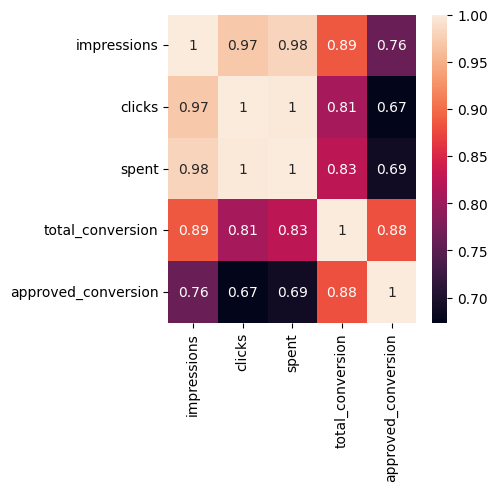

In [11]:
# correlation among numerical features:

corr = df.corr()
fig, axes = plt.subplots(figsize=(4,4))
sns.heatmap(corr, annot=True);


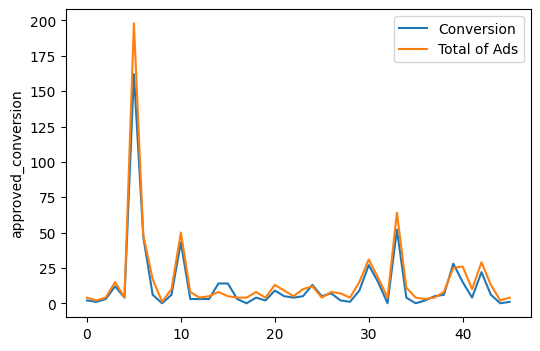

In [12]:
# I suspect that 'state' is not relevant, we will mostly have more conversions on the states where we had more ads, 
# the graph below will show how close the ammount of ads directed to one area is proportional to the ammount of conversions

fig, axes = plt.subplots(figsize=(6,4))
sns.lineplot(data = state_comp['approved_conversion'],label='Conversion' )
sns.lineplot(data = state_comp['total'], label='Total of Ads');

### Modeling


Use KMeans to create various customer segments

Use an Elbow Plot of inertia

And a plot of Silhouette Scores

Choose a K based on the results

In [18]:
#we can drop state columns since it is not relevant to our model, 
#now we will identify our clusters, and also drop the reporting day and campaign_id
df_m = df.drop(columns=['state', 'reporting_day', 'campaign_id'])

In [19]:
df_m.head()

,age,gender,education,marital,impressions,clicks,spent,total_conversion,approved_conversion
0,30-34,M,high.school,married,7350,1,1.43,2,1
1,30-34,M,professional.course,married,17861,2,1.82,2,0
2,30-34,M,university.degree,married,693,0,0.00,1,0
3,30-34,M,high.school,single,4259,1,1.25,1,0
4,30-34,M,professional.course,single,4133,1,1.29,1,1


In [20]:
# now we will scale the data

# Selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# we don't have missing data, but in case we use this model in the future with a new dataset that has missing data, 
# I'll leave this here:

# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)


In [21]:
# PipeLines

numeric_pipe = make_pipeline(mean_imputer, scaler)
categorical_pipe = make_pipeline(freq_imputer, ohe)

# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023A6E025430>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023A6E025490>)])

In [25]:
#Fit and Transform

df_trans = pd.DataFrame(preprocessor.fit_transform(df_m))
df_trans

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.389356,-0.438620,-0.422895,-0.039815,0.139713,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,-0.346647,-0.408033,-0.416122,-0.039815,-0.464387,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.416406,-0.469206,-0.447728,-0.286149,-0.464387,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,-0.401916,-0.438620,-0.426021,-0.286149,-0.464387,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,-0.402428,-0.438620,-0.425326,-0.286149,0.139713,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,-0.379511,-0.438620,-0.422374,-0.286149,-0.464387,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
757,1.466317,1.885949,1.697816,0.206519,0.139713,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
758,1.525008,1.824776,1.909679,0.206519,0.139713,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
759,1.323190,1.549498,1.581986,0.452853,0.743812,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
### fixing the name of the features

In [27]:
cat_cols = cat_selector(df_m)
cat_cols

['age', 'gender', 'education', 'marital']

In [35]:
num_cols = num_selector(df_m)
num_cols

['impressions', 'clicks', 'spent', 'total_conversion', 'approved_conversion']

In [33]:
## Finding the categorical pipeline in our col transformer.
preprocessor.named_transformers_['pipeline-2']

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [34]:
# Using list-slicing to find the encoder 
cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)

In [36]:
final_features = [*num_cols, *cat_features]
len(final_features)

16

In [37]:
df_trans = pd.DataFrame(preprocessor.fit_transform(df_m), 
                          columns=final_features, index=df_m.index)
df_trans.head()

,impressions,clicks,spent,total_conversion,approved_conversion,age_30-34,age_35-39,age_40-44,age_45-49,gender_F,gender_M,education_high.school,education_professional.course,education_university.degree,marital_married,marital_single
0,-0.389356,-0.438620,-0.422895,-0.039815,0.139713,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,-0.346647,-0.408033,-0.416122,-0.039815,-0.464387,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.416406,-0.469206,-0.447728,-0.286149,-0.464387,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,-0.401916,-0.438620,-0.426021,-0.286149,-0.464387,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,-0.402428,-0.438620,-0.425326,-0.286149,0.139713,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [38]:
# Find K

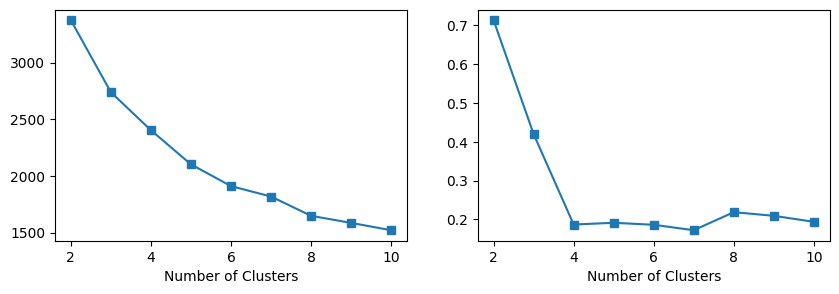

In [43]:
# Finding best # of clusters

inertias = []
sil_score = []

for k in range(2,11):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(df_trans)
  inertias.append(kmeans.inertia_)
  sil_score.append(silhouette_score(df_trans,kmeans.labels_))

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(range(2,11),inertias, marker = 's')
plt.xlabel('Number of Clusters')

plt.subplot(1,2,2)
plt.plot(range(2,11),sil_score, marker = 's')
plt.xlabel('Number of Clusters');


In [44]:
# Silhouete scor based on 2 clusters:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df_trans)
silhouette_score(df_trans, kmeans.labels_)

0.7127400979553048

In [45]:
# this is a great score, lets visualize it

In [46]:
# adding a columns with the labels for each cluster:

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df_trans)
df_trans['cluster'] = kmeans.labels_

#group by cluster
cluster_groups = df_trans.groupby('cluster', as_index=False).mean()
cluster_groups

,cluster,impressions,clicks,spent,total_conversion,approved_conversion,age_30-34,age_35-39,age_40-44,age_45-49,gender_F,gender_M,education_high.school,education_professional.course,education_university.degree,marital_married,marital_single
0,0,-0.161526,-0.155308,-0.156964,-0.156074,-0.137958,0.421341,0.236662,0.186047,0.155951,0.376197,0.623803,0.329685,0.332421,0.337893,0.508892,0.491108
1,1,3.935839,3.784347,3.824686,3.802994,3.361577,0.633333,0.233333,0.100000,0.033333,0.000000,1.000000,0.433333,0.366667,0.200000,0.300000,0.700000


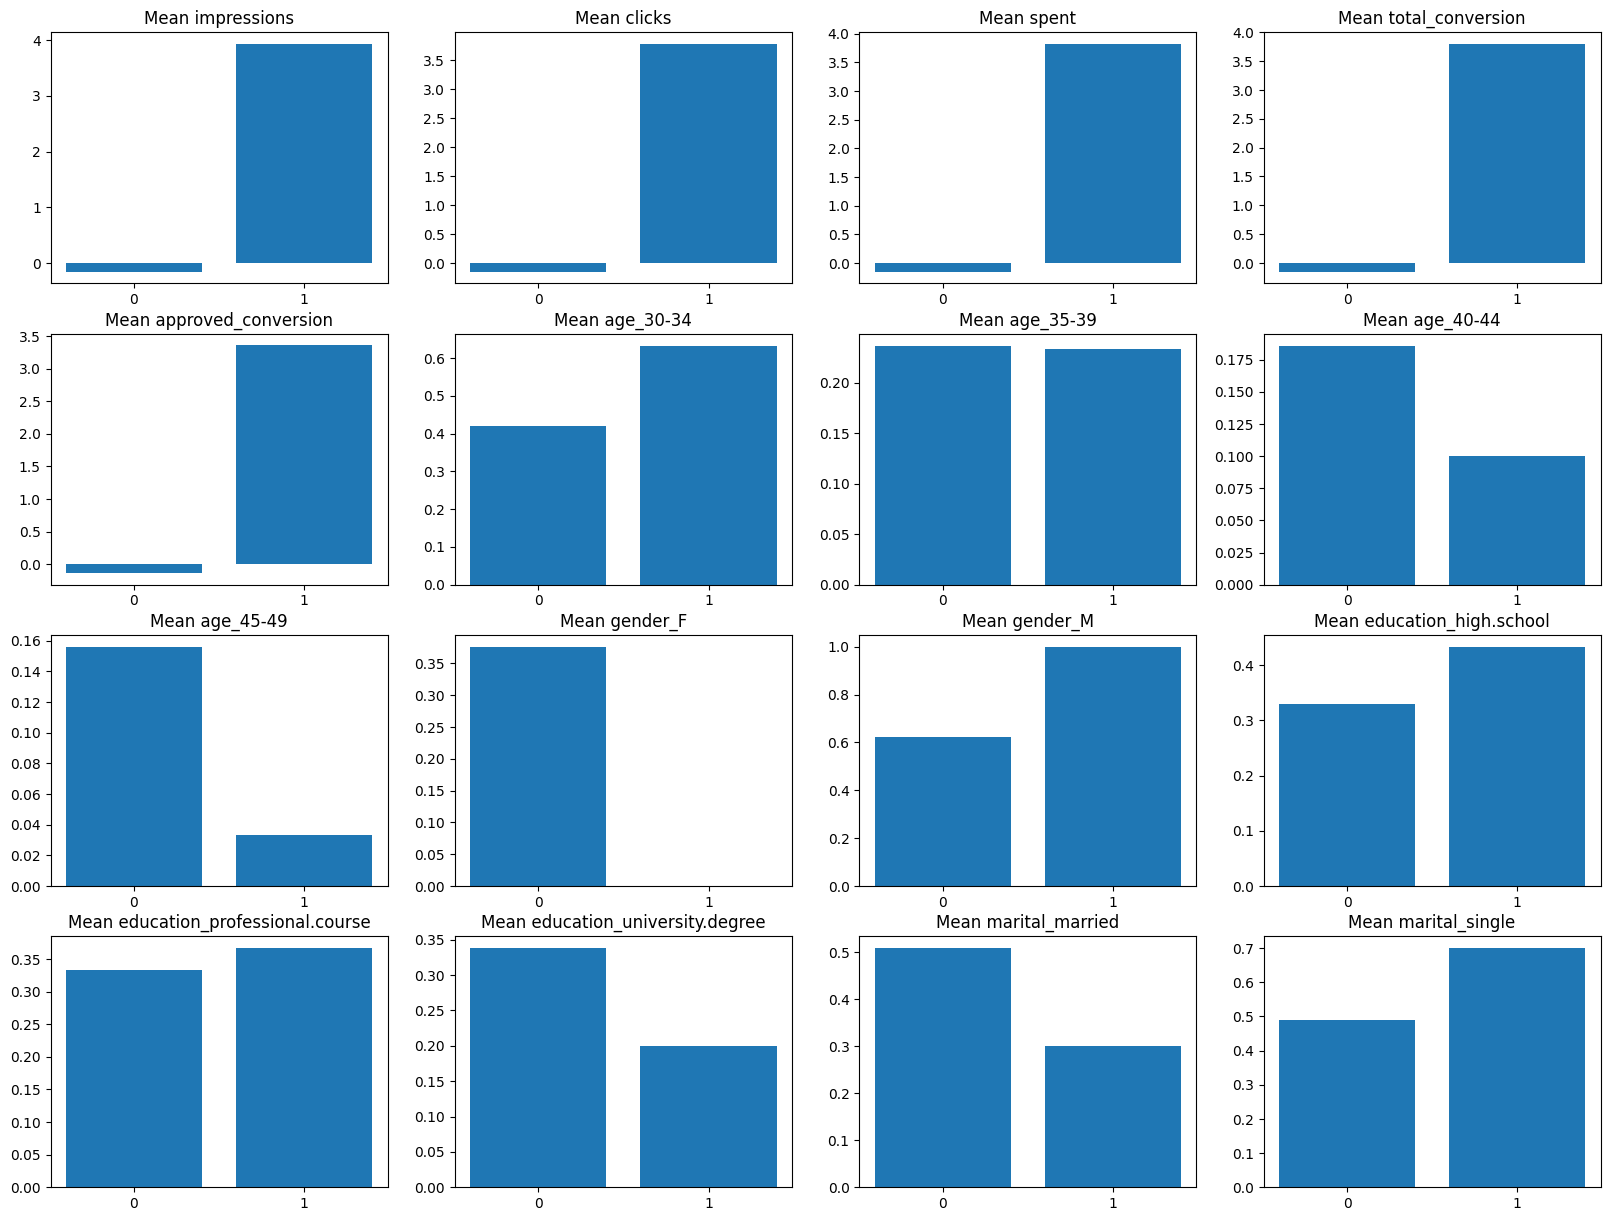

In [49]:
fig, axes = plt.subplots(4,4, figsize = (20, 15))

axes = axes.ravel()

for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')
  axes[i].set_xticks([0,1])